In [1]:
import pandas as pd
import numpy as np
from scipy import stats

#Data analysis
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler,PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

#Sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler,NearMiss,NeighbourhoodCleaningRule,ClusterCentroids,CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection,AllKNN,EditedNearestNeighbours,RepeatedEditedNearestNeighbours,TomekLinks
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.over_sampling import ADASYN 

#Visualizing sampling output, dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# For model buidling
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Custom module for prediction and model evalution
from utils import predict_and_evaluate


In [2]:
df_ml = pd.read_csv("../../../data/hyp_pay_fill_0.1 -1.csv")

In [3]:
#df_ml.drop(["Unnamed: 0","State","NPI"],axis =1,inplace= True)
df_ml.drop(["Unnamed: 0.1","Unnamed: 0","State","NPI"],axis =1,inplace= True)

df_ml = df_ml.round(2)

In [4]:
#df_ml.to_csv("ml_noNPI.csv")

In [5]:
df_ml.isna().sum()

Speciality                            1
max_Tot_Drug_Cst                      0
sum_Tot_Drug_Cst                      0
avg_Tot_Drug_Cst                      0
max_Total_claims                      0
                                     ..
Pen Needle, Diabetic_Tot_Day_Suply    0
Tramadol Hcl_Tot_Drug_Cst             0
Tramadol Hcl_Tot_Clms                 0
Tramadol Hcl_Tot_Day_Suply            0
Total_payments                        0
Length: 120, dtype: int64

### Missing value treatment

In [6]:
print("Total values in Payments : ",df_ml.index.max())
print("Missing values in Payments : ",df_ml["Total_payments"].isna().sum())
print("percentage of missing values",df_ml["Total_payments"].isna().sum()/df_ml.index.max()*100,"%")

#Over 60% of payments  data is missing in total dataframe

Total values in Payments :  965055
Missing values in Payments :  0
percentage of missing values 0.0 %


In [7]:
print("Total values in Fraud Payments : ",df_ml[df_ml.FRAUD == 1].count().head(1))
print("Missing values in Payments : ",df_ml[df_ml["FRAUD"] == 1]["Total_payments"].isna().sum()) 
print("percentage of missing values",df_ml[df_ml["FRAUD"] == 1]["Total_payments"].isna().sum()/df_ml[df_ml.FRAUD == 1].count().head(1)*100)

#Over 50% of payments data is missing for fraud =1

Total values in Fraud Payments :  Speciality    886
dtype: int64
Missing values in Payments :  0
percentage of missing values Speciality    0.0
dtype: float64


In [8]:
#Dropping payments attribute as more than 50% data is missing.
#shifting fraud columns to the end

df_ml["fraud"] = df_ml["FRAUD"]

#df_ml.drop(["Total_payments","FRAUD"],axis=1,inplace = True)

df_ml.drop("FRAUD",axis=1,inplace = True)
#df_ml = test.drop("Total_payments",axis =1)
#df_ml = test.copy()

In [9]:
df_ml["Total_payments"].isnull().sum()

0

In [10]:
df_ml["Total_payments"].describe()

count    9.650560e+05
mean     3.325485e+03
std      4.080248e+04
min      1.400000e-01
25%      1.834000e+02
50%      5.831300e+02
75%      2.033898e+03
max      1.834759e+07
Name: Total_payments, dtype: float64

<AxesSubplot:>

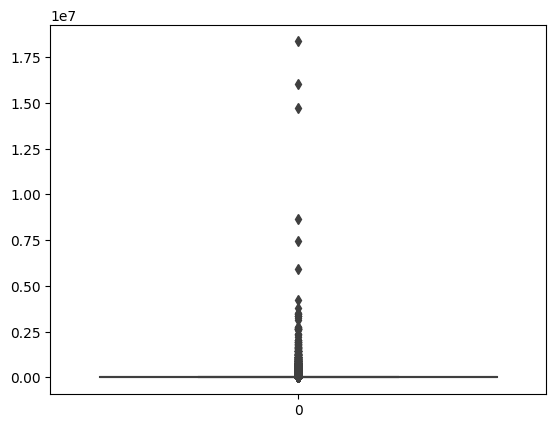

In [11]:
sns.boxplot(df_ml["Total_payments"])

### Scaling

In [12]:
df_ml.columns

Index(['Speciality', 'max_Tot_Drug_Cst', 'sum_Tot_Drug_Cst',
       'avg_Tot_Drug_Cst', 'max_Total_claims', 'sum_Total_claims',
       'avg_Total_claims', 'max_Tot_Day_Suply', 'sum_Tot_Day_Suply',
       'avg_Tot_Day_Suply',
       ...
       'Lisinopril/Hydrochlorothiazide_Tot_Day_Suply', 'Diazepam_Tot_Clms',
       'Diazepam_Tot_Day_Suply', 'Pen Needle, Diabetic_Tot_Drug_Cst',
       'Pen Needle, Diabetic_Tot_Day_Suply', 'Tramadol Hcl_Tot_Drug_Cst',
       'Tramadol Hcl_Tot_Clms', 'Tramadol Hcl_Tot_Day_Suply', 'Total_payments',
       'fraud'],
      dtype='object', length=120)

In [13]:
scale_features = df_ml.columns.to_list()[1:16]
scale_features.append("Total_payments")
scale_features

['max_Tot_Drug_Cst',
 'sum_Tot_Drug_Cst',
 'avg_Tot_Drug_Cst',
 'max_Total_claims',
 'sum_Total_claims',
 'avg_Total_claims',
 'max_Tot_Day_Suply',
 'sum_Tot_Day_Suply',
 'avg_Tot_Day_Suply',
 'max_Tot_30day_Fills',
 'sum_Tot_30day_Fills',
 'avg_Tot_30day_Fills',
 'claim_max-mean',
 'supply_max-mean',
 'drug_max-mean',
 'Total_payments']

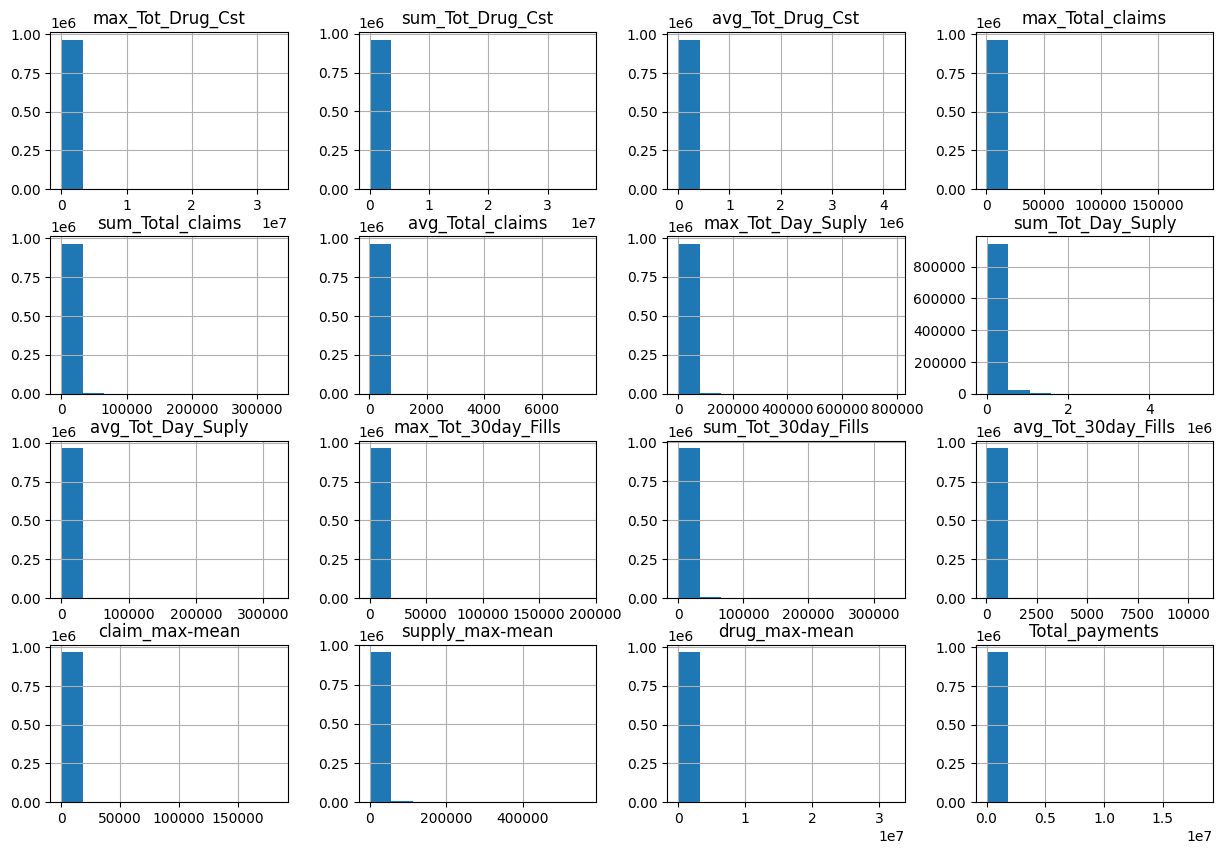

In [14]:
#All distribution negatively skewed

df_ml[scale_features].hist(figsize=(15, 10));

### Power transformer scaler: 
since all features has positive skew, log scale will help to make distribution normal

In [15]:
pt = PowerTransformer()

In [16]:
df_pscale = df_ml.copy()
df_pscale[scale_features] = pd.DataFrame(
    pt.fit_transform(df_pscale.loc[:,scale_features]), columns=scale_features
)

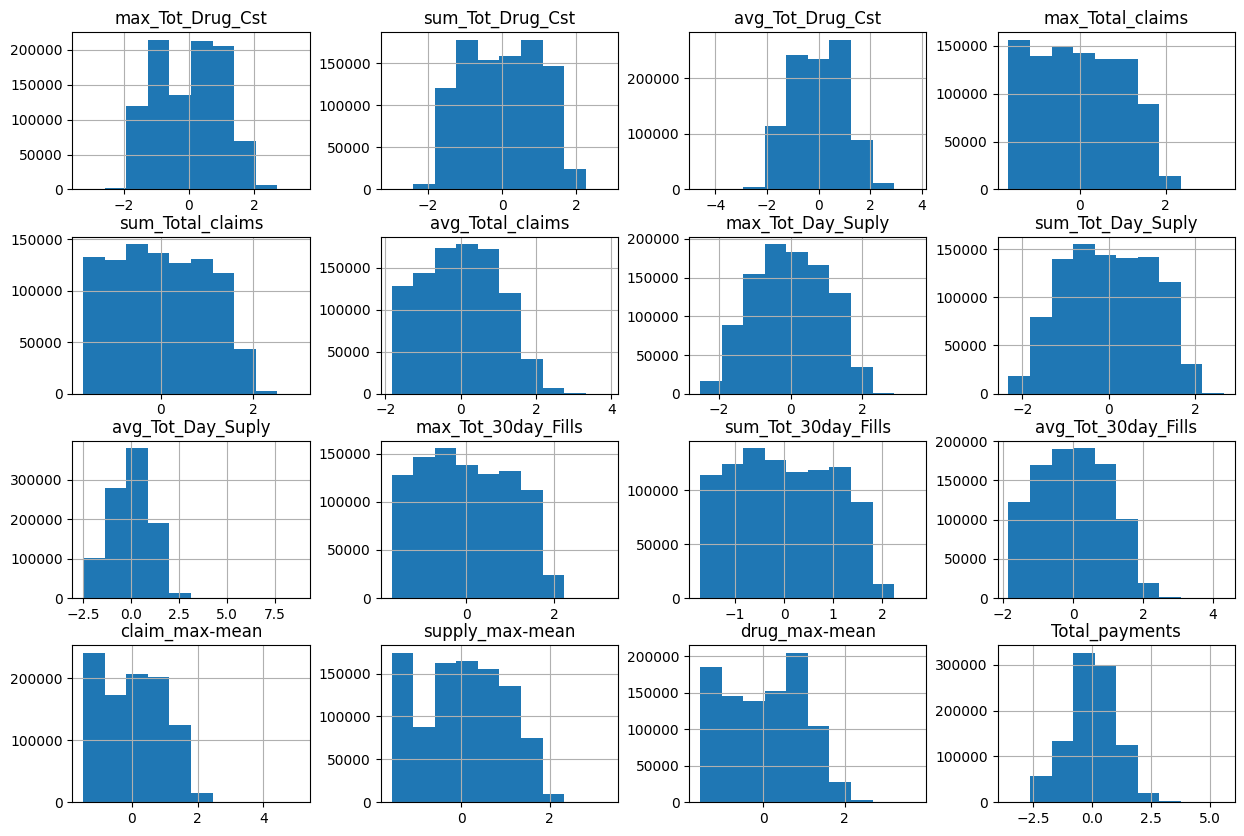

In [17]:
df_pscale[scale_features].hist(figsize=(15, 10));

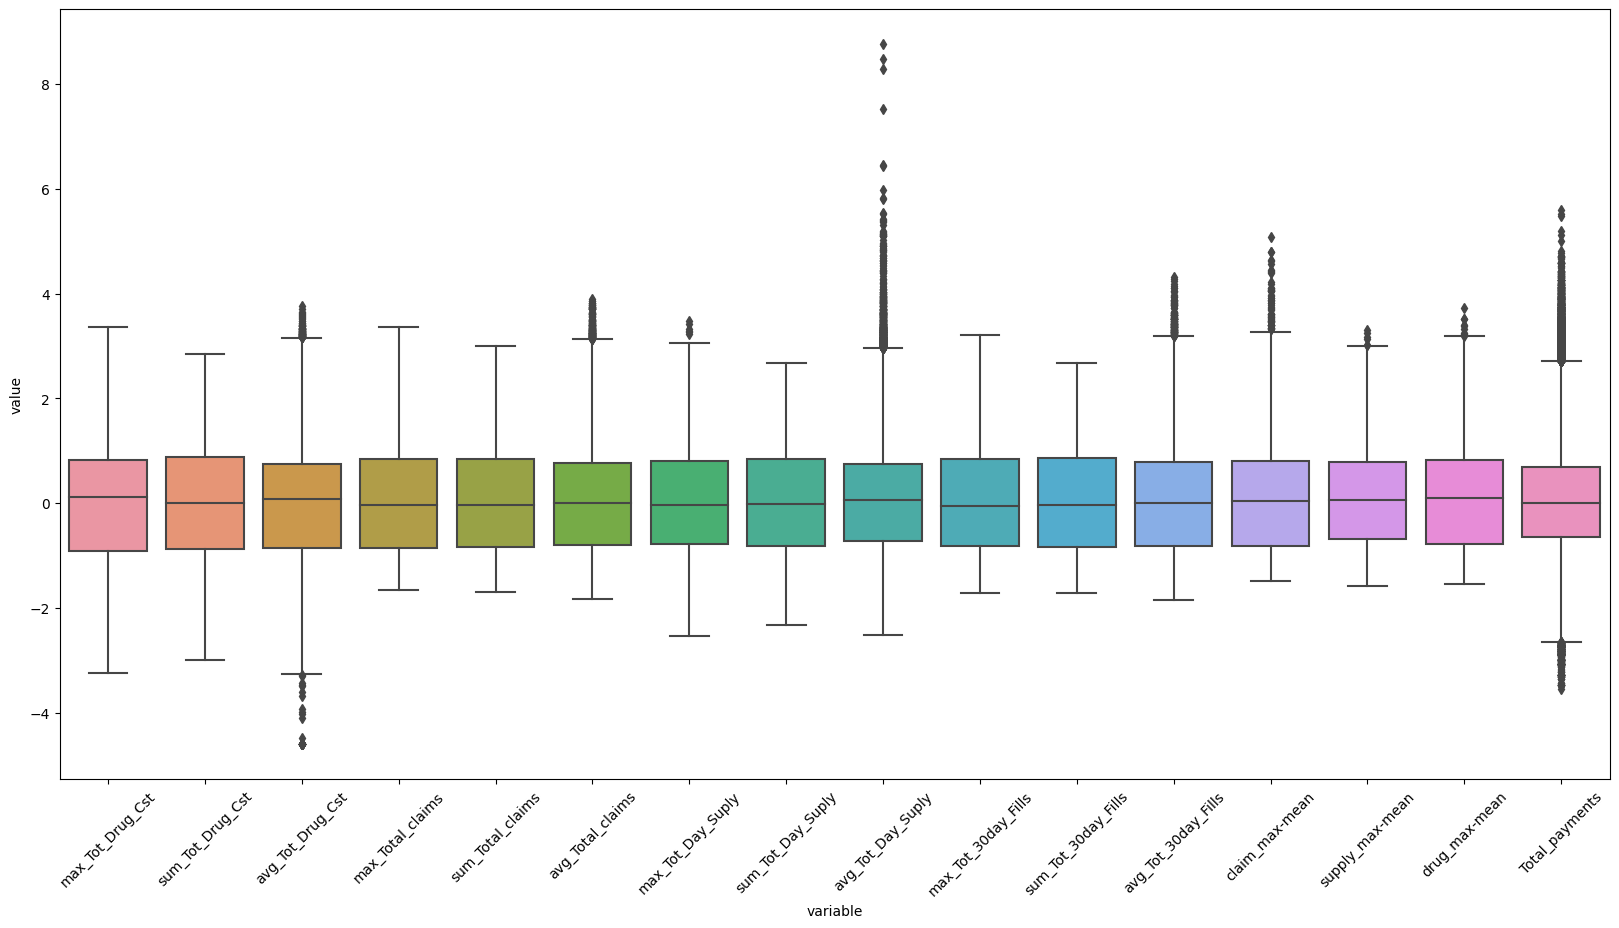

In [18]:
#df_pscale.loc[:,scale_features].boxplot(figsize=(20, 5));
#plt.xticks(rotation = 45);


#outliers in avg_total drug cost, avg_total daily supply, claim max mean
plt.figure(figsize=(20,10));
sns.boxplot(x="variable", y="value", data=pd.melt(df_pscale[scale_features]));
plt.xticks(rotation = 45);

#### Outlier removal

#if outlier removal happens now, already unbalanced target may get more balanced

z = np.abs(stats.zscore(df_pscale[scale_features]))
df_filtered = df_pscale[(z < 3).all(axis=1)]
print("Before outlier removal",df_pscale.shape)
print("Remaining after outlier removal",df_filtered.shape)
sns.set(style="darkgrid")
ax = sns.countplot(x="fraud", data=df_filtered)

### Standard scaler : 
    centering : sub mean from each value
    scaling : divide by std
    not suitable for skewed dist,as it will not decrease the skewness lets see it in action

In [19]:
ss = StandardScaler()

In [20]:
#No change in skewness

df_stdscale =  df_ml.copy()
df_stdscale[scale_features] = pd.DataFrame(
    ss.fit_transform(df_stdscale.loc[:,scale_features]), columns=scale_features
)

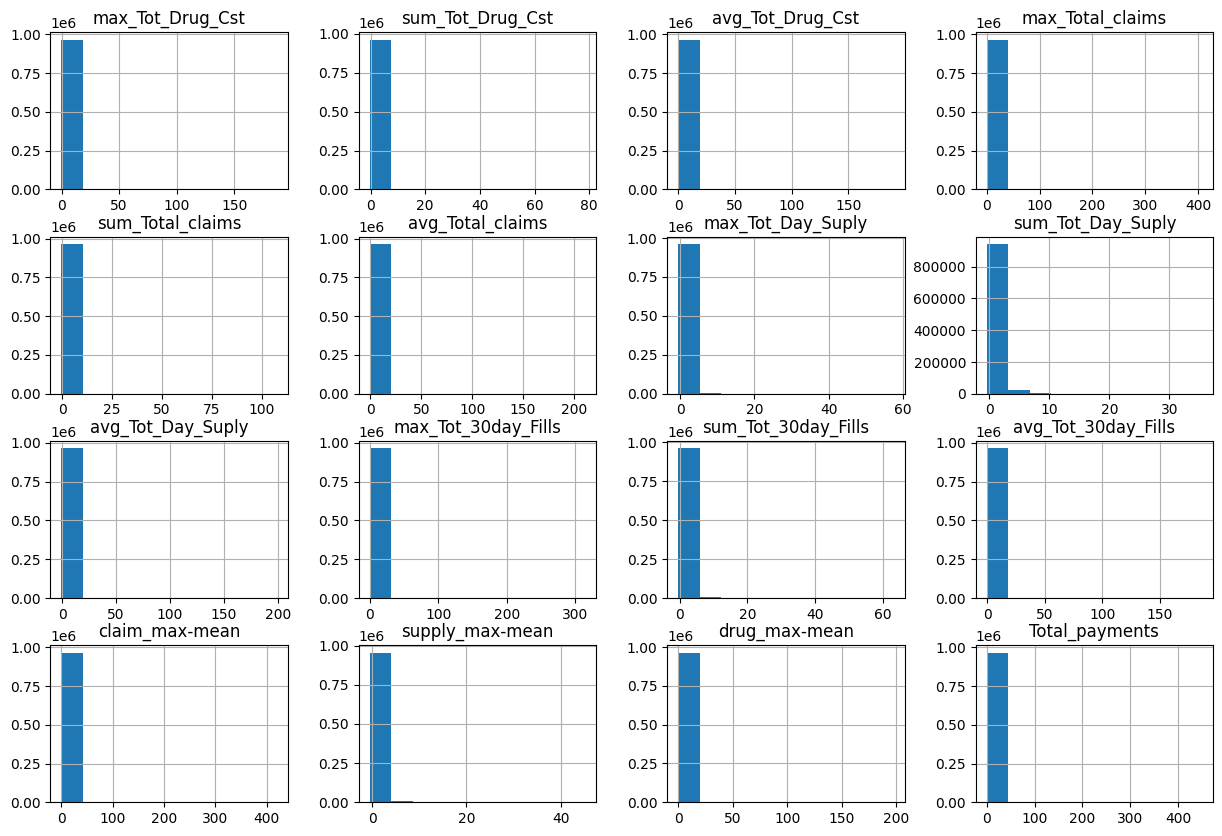

In [21]:
df_stdscale[scale_features].hist(figsize=(15, 10));

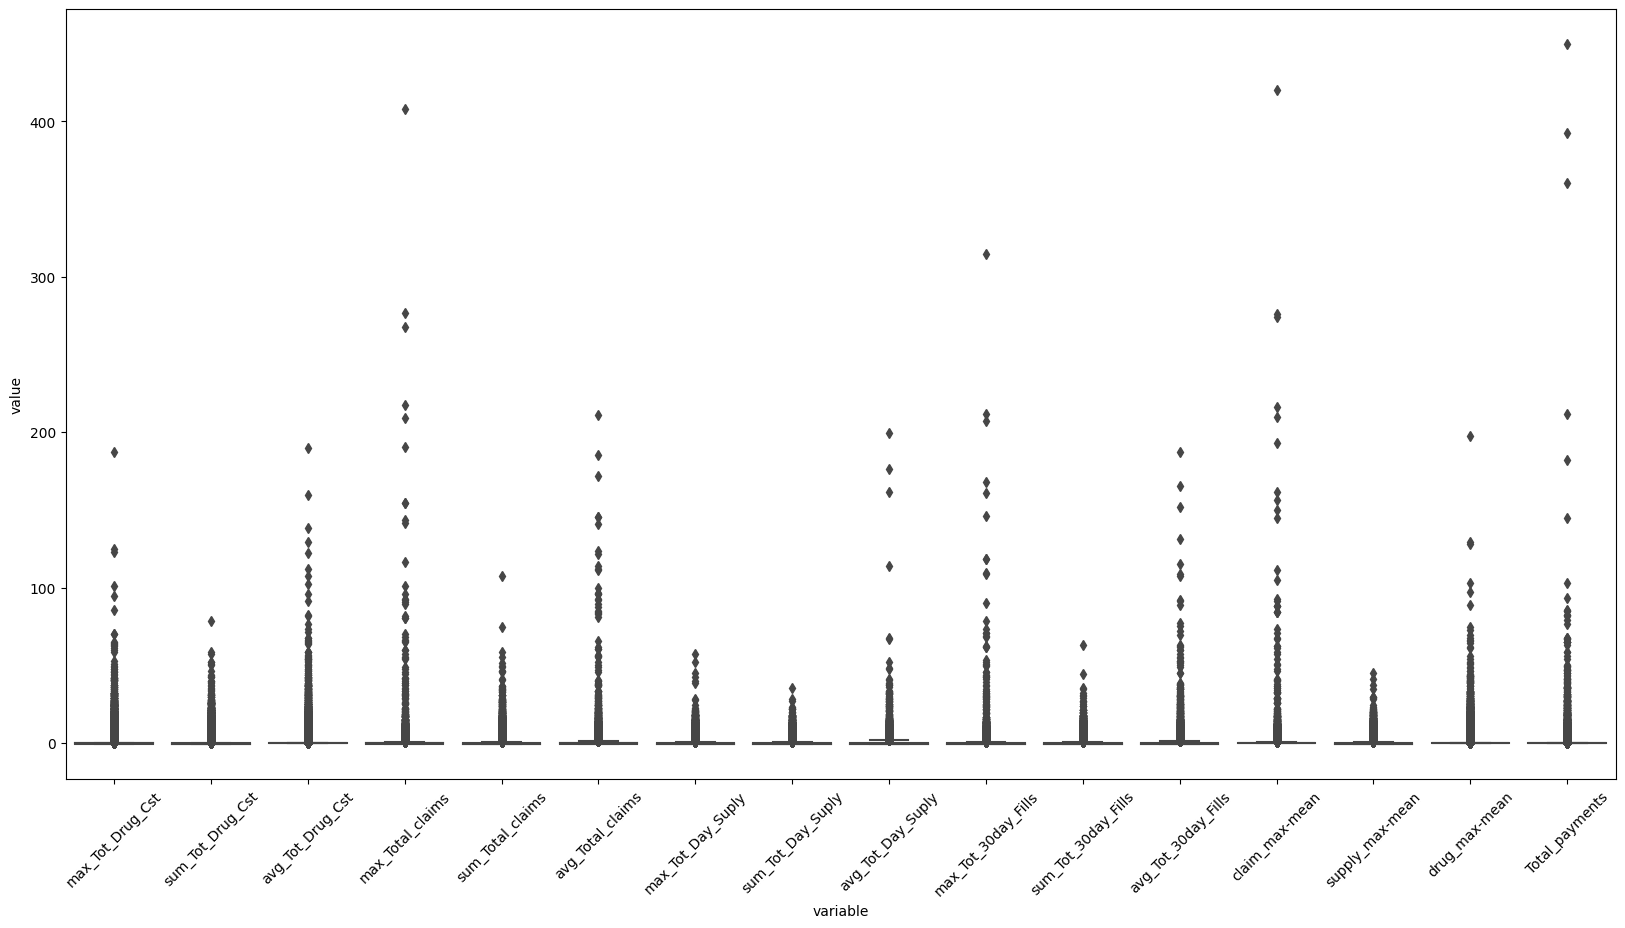

In [22]:
#outliers in avg_total drug cost, avg_total daily supply, claim max mean
plt.figure(figsize=(20,10));
sns.boxplot(x="variable", y="value", data=pd.melt(df_stdscale[scale_features]));
plt.xticks(rotation = 45);

### Robust scaler : 
    robust to outliers
    

In [23]:
rb = RobustScaler()

In [24]:
#No change in skewness again

df_rbscale =  df_ml.copy()
df_rbscale[scale_features] = pd.DataFrame(
    rb.fit_transform(df_rbscale.loc[:,scale_features]), columns=scale_features
)

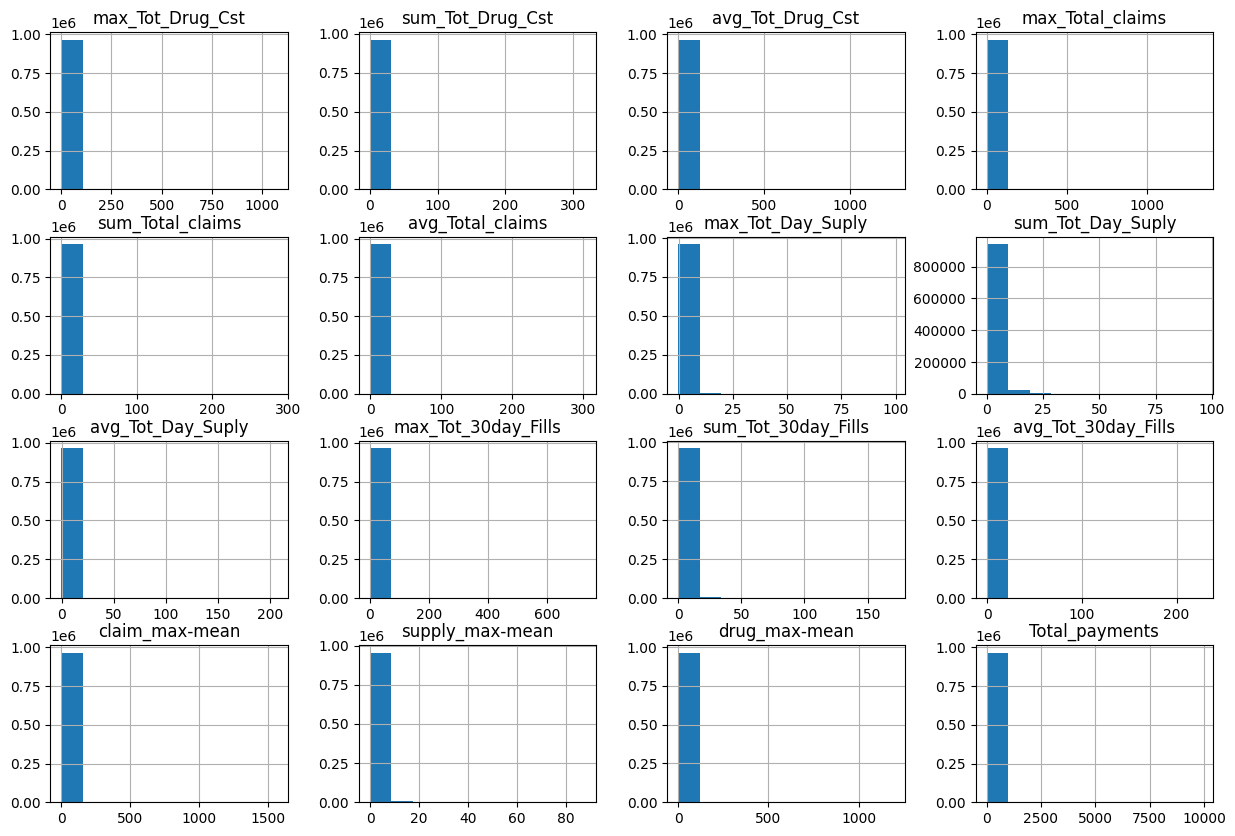

In [25]:
df_rbscale[scale_features].hist(figsize=(15, 10));

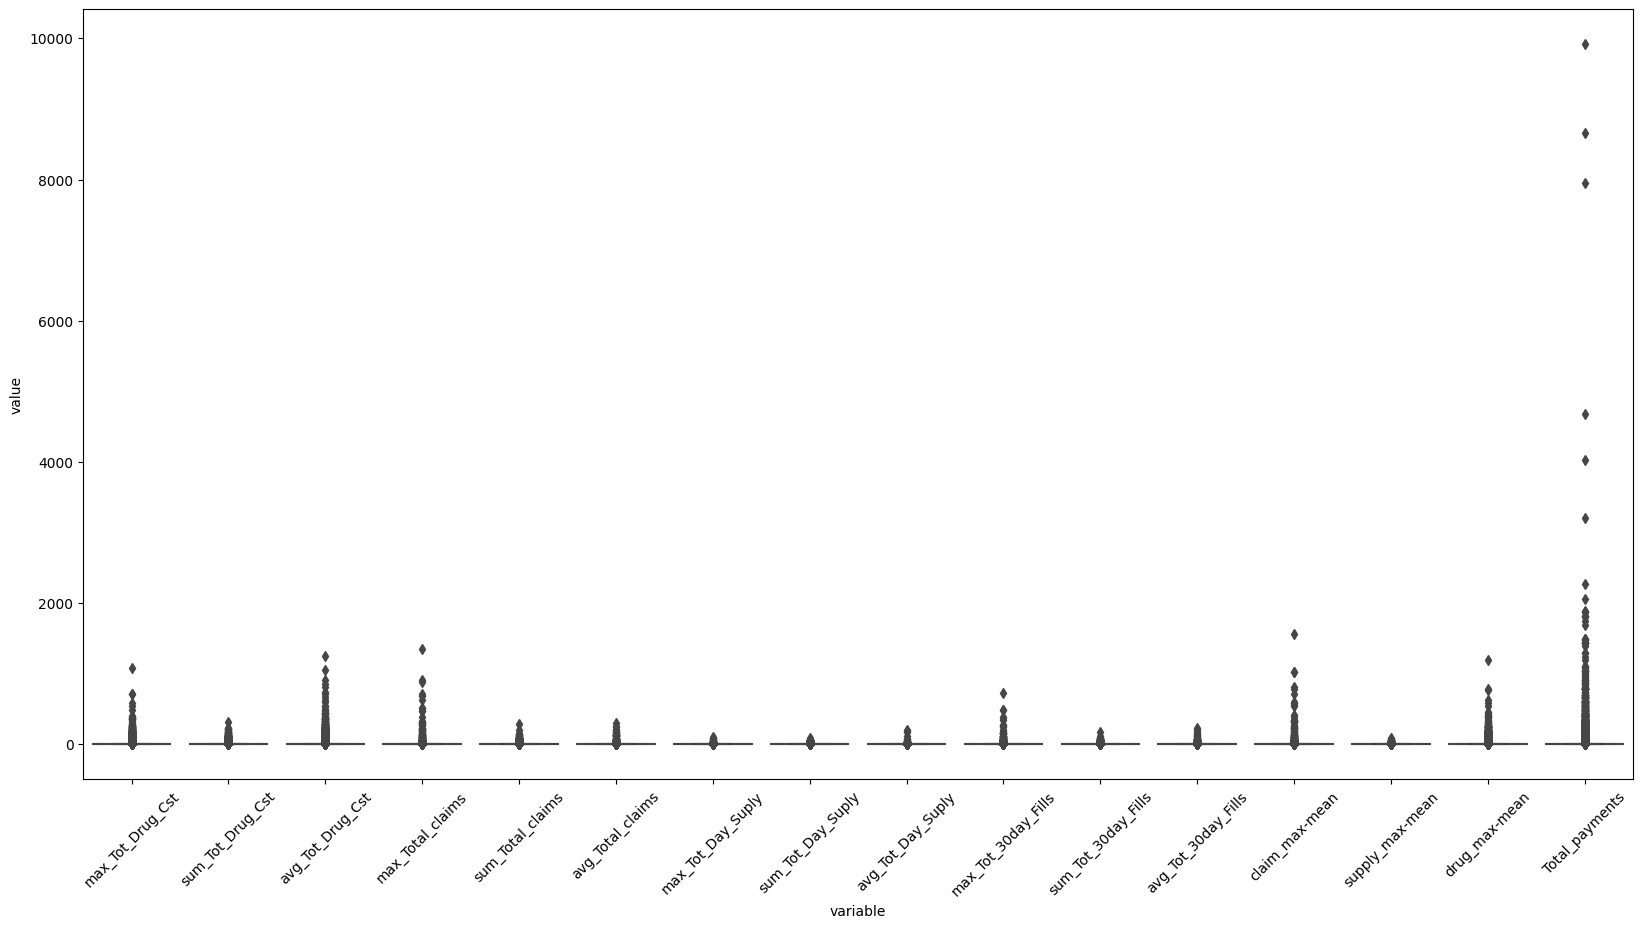

In [26]:
#outliers in avg_total drug cost, avg_total daily supply, claim max mean
plt.figure(figsize=(20,10));
sns.boxplot(x="variable", y="value", data=pd.melt(df_rbscale[scale_features]));
plt.xticks(rotation = 45);

### Scaler assignment

In [27]:
#copying scaled output to new variable for further processiing

df_scale = df_pscale.copy()

In [28]:
df_scale.head(1)

,Speciality,max_Tot_Drug_Cst,sum_Tot_Drug_Cst,avg_Tot_Drug_Cst,max_Total_claims,sum_Total_claims,avg_Total_claims,max_Tot_Day_Suply,sum_Tot_Day_Suply,avg_Tot_Day_Suply,...,Lisinopril/Hydrochlorothiazide_Tot_Day_Suply,Diazepam_Tot_Clms,Diazepam_Tot_Day_Suply,"Pen Needle, Diabetic_Tot_Drug_Cst","Pen Needle, Diabetic_Tot_Day_Suply",Tramadol Hcl_Tot_Drug_Cst,Tramadol Hcl_Tot_Clms,Tramadol Hcl_Tot_Day_Suply,Total_payments,fraud
0,internal medicine,0.121148,-0.11636,-0.087135,-0.580412,-0.297019,-1.043478,-0.380311,-0.210963,-0.443933,...,0,0,0,0.0,0,0.0,0,0,-1.861172,0


In [29]:
#Only one missing value in Speciality

df_scale.isnull().sum().to_dict()

{'Speciality': 1,
 'max_Tot_Drug_Cst': 0,
 'sum_Tot_Drug_Cst': 0,
 'avg_Tot_Drug_Cst': 0,
 'max_Total_claims': 0,
 'sum_Total_claims': 0,
 'avg_Total_claims': 0,
 'max_Tot_Day_Suply': 0,
 'sum_Tot_Day_Suply': 0,
 'avg_Tot_Day_Suply': 0,
 'max_Tot_30day_Fills': 0,
 'sum_Tot_30day_Fills': 0,
 'avg_Tot_30day_Fills': 0,
 'claim_max-mean': 0,
 'supply_max-mean': 0,
 'drug_max-mean': 0,
 'Methocarbamol_Tot_Drug_Cst': 0,
 'Atorvastatin Calcium_Tot_Drug_Cst': 0,
 'Atorvastatin Calcium_Tot_Clms': 0,
 'Atorvastatin Calcium_Tot_Day_Suply': 0,
 'Gabapentin_Tot_Drug_Cst': 0,
 'Gabapentin_Tot_Clms': 0,
 'Gabapentin_Tot_Day_Suply': 0,
 'Abatacept_Tot_Drug_Cst': 0,
 'Abatacept_Tot_Clms': 0,
 'Abatacept_Tot_Day_Suply': 0,
 'Risperidone Microspheres_Tot_Drug_Cst': 0,
 'Risperidone Microspheres_Tot_Day_Suply': 0,
 'Sildenafil Citrate_Tot_Clms': 0,
 'Sildenafil Citrate_Tot_Day_Suply': 0,
 'Doxycycline Hyclate_Tot_Clms': 0,
 'Lisinopril_Tot_Clms': 0,
 'Lisinopril_Tot_Day_Suply': 0,
 'Clonazepam_Tot_Drug_Cs

In [30]:
#FFilled missing value with most occuring speciality

df_scale["Speciality"].fillna(df_scale.Speciality.mode,inplace = True)
df_scale["Speciality"].isnull().sum()

0

From visualization in combined data : fraud categories were
dentist : 278
internal medicine : 213
family practice : 129
'general practice' : 53
podiatry : 41
psychiatry : 36
neurology: 15

From fruad data : has generalised types
Nurse/nurses aide : 32k
Family practice/GP : 2K
Dentist : 1k
owner operator : 3k
heatlh care aid : 3k
personal care provider : 2k

In [31]:
print("Unique speciality throughout dataset:" )
print(df_scale["Speciality"].value_counts().count())

#speciality_cat = pd.DataFrame.from_dict(df_ml["Speciality"].value_counts().to_dict(),orient='index',columns=["count"])
#print(df_ml[df_ml["FRAUD"] == 1]["Speciality"].value_counts().to_dict())

#df_ml["Speciality"].value_counts().sort_values(ascending=False).head(60)

Unique speciality throughout dataset:
181


In [32]:
df_scale["Speciality"].value_counts().to_dict()

#req_cat = ['nurse practitioner','internal medicine','family practice','dentist','general practice','physician assistant','emergency medicine',
          #'psychiatry']

{'nurse practitioner': 155588,
 'internal medicine': 99164,
 'family practice': 99025,
 'dentist': 97416,
 'physician assistant': 82502,
 'emergency medicine': 31088,
 'student in an organized health care education/training program': 23929,
 'optometry': 23319,
 'obstetrics & gynecology': 23085,
 'pharmacist': 22427,
 'psychiatry': 21367,
 'cardiology': 18733,
 'orthopedic surgery': 18372,
 'ophthalmology': 18089,
 'general surgery': 14721,
 'gastroenterology': 13415,
 'neurology': 13401,
 'podiatry': 12999,
 'dermatology': 12650,
 'hospitalist': 10642,
 'psychiatry & neurology': 9917,
 'urology': 9717,
 'pulmonary disease': 8923,
 'otolaryngology': 8734,
 'nephrology': 8607,
 'hematology-oncology': 8134,
 'general practice': 7306,
 'physical medicine and rehabilitation': 7101,
 'endocrinology': 6038,
 'oral surgery (dentist only)': 5169,
 'infectious disease': 5077,
 'rheumatology': 4871,
 'interventional cardiology': 3897,
 'pediatric medicine': 3724,
 'allergy/ immunology': 3636,
 '

In [33]:
# make list with top 30 variables
top_30 = [x for x in df_scale.Speciality.value_counts().sort_values(ascending=False).head(30).index]
#top_30.append('anesthesiology')
top_30

['nurse practitioner',
 'internal medicine',
 'family practice',
 'dentist',
 'physician assistant',
 'emergency medicine',
 'student in an organized health care education/training program',
 'optometry',
 'obstetrics & gynecology',
 'pharmacist',
 'psychiatry',
 'cardiology',
 'orthopedic surgery',
 'ophthalmology',
 'general surgery',
 'gastroenterology',
 'neurology',
 'podiatry',
 'dermatology',
 'hospitalist',
 'psychiatry & neurology',
 'urology',
 'pulmonary disease',
 'otolaryngology',
 'nephrology',
 'hematology-oncology',
 'general practice',
 'physical medicine and rehabilitation',
 'endocrinology',
 'oral surgery (dentist only)']

In [34]:
# for all categorical variables we selected
def top_x(df2,variable,top_x_labels):
    for label in top_x_labels:
        df2[variable+'_'+label] = np.where(df_scale[variable]==label,1,0)

In [35]:
#encode Nighborhood into the 10 most frequent categories
top_x(df_scale,'Speciality',top_30)
# display data
df_scale.tail(2)

,Speciality,max_Tot_Drug_Cst,sum_Tot_Drug_Cst,avg_Tot_Drug_Cst,max_Total_claims,sum_Total_claims,avg_Total_claims,max_Tot_Day_Suply,sum_Tot_Day_Suply,avg_Tot_Day_Suply,...,Speciality_psychiatry & neurology,Speciality_urology,Speciality_pulmonary disease,Speciality_otolaryngology,Speciality_nephrology,Speciality_hematology-oncology,Speciality_general practice,Speciality_physical medicine and rehabilitation,Speciality_endocrinology,Speciality_oral surgery (dentist only)
965054,dentist,-1.502336,-1.420147,-1.613130,-1.469526,-1.226502,-1.625988,-1.599178,-1.503941,-1.773079,...,0,0,0,0,0,0,0,0,0,0
965055,dentist,-1.372325,-1.472529,-1.276595,-0.457970,-1.023326,0.441683,-1.263286,-1.372712,-1.164347,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_scale["Speciality_nurse practitioner"].value_counts()

0    809468
1    155588
Name: Speciality_nurse practitioner, dtype: int64

In [37]:
#Total columns 226 , fraud column at the end

df_scale.columns

Index(['Speciality', 'max_Tot_Drug_Cst', 'sum_Tot_Drug_Cst',
       'avg_Tot_Drug_Cst', 'max_Total_claims', 'sum_Total_claims',
       'avg_Total_claims', 'max_Tot_Day_Suply', 'sum_Tot_Day_Suply',
       'avg_Tot_Day_Suply',
       ...
       'Speciality_psychiatry & neurology', 'Speciality_urology',
       'Speciality_pulmonary disease', 'Speciality_otolaryngology',
       'Speciality_nephrology', 'Speciality_hematology-oncology',
       'Speciality_general practice',
       'Speciality_physical medicine and rehabilitation',
       'Speciality_endocrinology', 'Speciality_oral surgery (dentist only)'],
      dtype='object', length=150)

In [38]:
df_scale.drop("Speciality",axis =1,inplace=True)

In [39]:
X = df_scale.drop('fraud', axis=1)
y = df_scale['fraud']

In [40]:
#obj creation stratifiedsplit

ss = StratifiedShuffleSplit(n_splits=1,
                            test_size=0.2,
                            train_size=0.8,
                            random_state=42)

In [41]:
#Strattified split

for train_index, test_index in ss.split(X, y):
    train_df = df_scale.iloc[train_index]
    test_df = df_scale.iloc[test_index]

In [42]:
train_df.shape

(772044, 149)

In [43]:
test_df.shape

(193012, 149)

In [44]:
train_df

,max_Tot_Drug_Cst,sum_Tot_Drug_Cst,avg_Tot_Drug_Cst,max_Total_claims,sum_Total_claims,avg_Total_claims,max_Tot_Day_Suply,sum_Tot_Day_Suply,avg_Tot_Day_Suply,max_Tot_30day_Fills,...,Speciality_psychiatry & neurology,Speciality_urology,Speciality_pulmonary disease,Speciality_otolaryngology,Speciality_nephrology,Speciality_hematology-oncology,Speciality_general practice,Speciality_physical medicine and rehabilitation,Speciality_endocrinology,Speciality_oral surgery (dentist only)
237749,-0.933382,-0.964062,-0.758334,-0.895997,-0.959005,-0.615830,-1.297382,-1.220647,-1.336034,-1.066706,...,0,0,0,0,0,0,0,0,0,0
916253,0.845698,0.680962,1.005042,0.534169,0.326565,0.591521,0.072287,0.257852,0.301584,0.199872,...,0,0,0,0,0,0,0,0,0,0
844288,-0.637029,-0.848703,-0.152513,-1.660880,-1.686869,-1.835595,-0.694819,-0.957488,-0.373365,-1.300160,...,0,0,0,0,0,0,0,0,0,0
514724,0.692940,0.819988,0.140610,1.307843,1.428639,1.083043,1.476434,1.482592,1.338674,1.487238,...,0,0,0,0,0,0,0,0,0,0
178288,1.115132,1.235027,1.536816,0.575811,0.493332,0.251846,0.753735,0.593392,0.593380,0.779837,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722593,0.238388,0.382165,0.151532,1.142665,0.911351,1.275090,0.693435,0.646030,0.540997,0.773375,...,0,0,0,0,0,0,0,0,0,0
78979,-0.800215,-0.683653,-0.911731,-1.051115,-0.472063,-1.115289,-0.750960,-0.368982,-0.540874,-1.198610,...,0,0,0,0,0,0,0,0,0,0
874339,-0.471791,-0.559054,-0.779222,0.261911,-0.147125,-0.207661,-0.254323,-0.439761,-0.787201,-0.029800,...,0,0,0,0,0,0,0,0,0,0
879174,-1.126383,-0.916243,-1.091366,-0.257689,-0.301399,0.275648,-0.535486,-0.632103,-0.753125,-0.513496,...,0,0,0,0,0,0,0,0,0,0


In [45]:
train_df.fraud.value_counts()

0    771335
1       709
Name: fraud, dtype: int64

In [46]:
test_df.fraud.value_counts()

0    192835
1       177
Name: fraud, dtype: int64

In [47]:
# Lets shuffle the data before creating the subsamples
train_df = train_df.sample(frac=1,random_state=2)

In [48]:
# Create X_train, X_test, y_train, y_test for ease of use
X_train = train_df.drop('fraud', axis=1)
y_train = train_df['fraud']

X_test = test_df.drop('fraud', axis=1)
y_test = test_df['fraud']

In [49]:
#rf_clf = RandomForestClassifier(n_estimators=100, criterion="entropy")

In [50]:
#rf_clf.fit(X_train, y_train)

In [51]:
# Decision Tree in the Forest
#rf_clf.estimators_[0]

## Sampling

### Under sampling

In [53]:
#function to plot the undersampled data
#t-Distributed Stochastic Neighbor Embedding (t-SNE) :tSNE shows accurate which 
#can depicts clearly separated Fraud and Non Fraud cases.

def plot_graph_tsne(X,y):
    pca_2d = TSNE(n_components=2, random_state=42).fit_transform(X.values)
    colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y]
    kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
    fig = plt.Figure(figsize=(12,6))
    plt.scatter(pca_2d[:, 0],pca_2d[:, 1], c=colors, **kwarg_params, label="Fraud")
    plt.legend()
    sns.despine()

In [54]:
#pca dimensionality reduction

def plot_graph_pca(X,y):
    pca_2d = PCA(n_components="mle", random_state=12).fit_transform(X.values)
    colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y]
    kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
    fig = plt.Figure(figsize=(12,6))
    plt.scatter(pca_2d[:, 0],pca_2d[:, 1], c=colors, **kwarg_params, label="Fraud")
    plt.legend()
    sns.despine()

#reset
#X_test = test_df.drop('fraud', axis=1)
#X_train = train_df.drop('fraud', axis=1)

#FOR compute intensive algo: reducing number of features to top 80
X_train = X_train[tst]
X_test = X_test[tst]

#### Under sampling 

In [55]:
sampler = RandomUnderSampler(sampling_strategy='auto')

#sampler = NearMiss(version = 3)

#sampler = ClusterCentroids(random_state=42) #COMPUTE INTENSIVE, as generates new centroid samples
 
#sampler = CondensedNearestNeighbour(random_state=42) #COMPUTE INTENSIVE

#sampler = EditedNearestNeighbours() #COMPUTE INTENSIVE

#sampler = OneSidedSelection()

#sampler = AllKNN()

#sampler = RepeatedEditedNearestNeighbours()

#sampler  = TomekLinks()

#bottom up approach setup

#### Combine sampling`

In [ ]:
#sampler  = SMOTETomek(random_state=42)

#sampler  = SMOTEENN()

#### Oversampling

In [ ]:
# sampler  =  ADASYN()

In [56]:
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_rs))

Resampled dataset shape Counter({0: 709, 1: 709})


C:\Users\Shailesh\Desktop\project\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Shailesh\Desktop\project\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


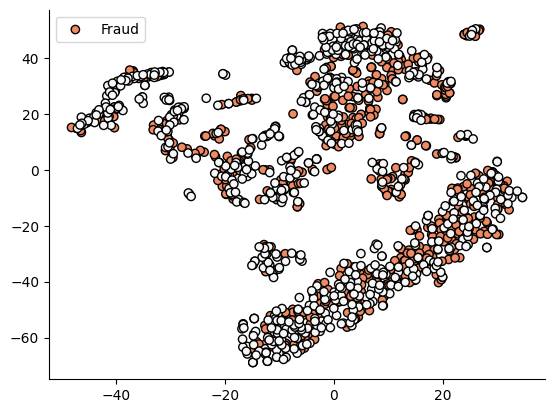

In [57]:
plot_graph_tsne(X_rs, y_rs)

#No clear seperation

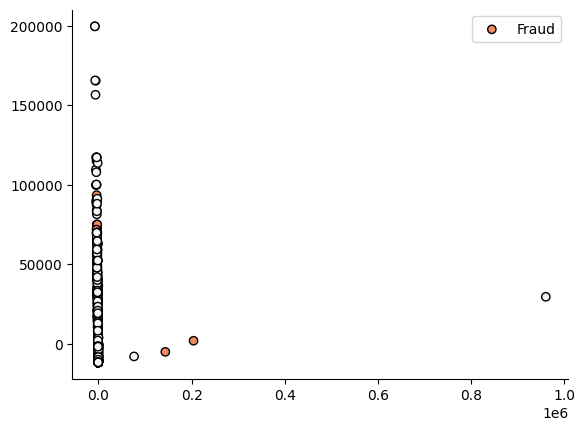

In [58]:
#pca doesnt help much

plot_graph_pca(X_rs, y_rs)

### Correlation analysis : Imbalanced and balanced dataset

In [59]:
df_under = pd.concat([X_rs, y_rs], axis=1)
df_under.head(1)

,max_Tot_Drug_Cst,sum_Tot_Drug_Cst,avg_Tot_Drug_Cst,max_Total_claims,sum_Total_claims,avg_Total_claims,max_Tot_Day_Suply,sum_Tot_Day_Suply,avg_Tot_Day_Suply,max_Tot_30day_Fills,...,Speciality_urology,Speciality_pulmonary disease,Speciality_otolaryngology,Speciality_nephrology,Speciality_hematology-oncology,Speciality_general practice,Speciality_physical medicine and rehabilitation,Speciality_endocrinology,Speciality_oral surgery (dentist only),fraud
0,1.1073,1.341237,1.536596,1.279999,0.976988,1.302,1.182504,0.892392,1.033631,1.222005,...,0,1,0,0,0,0,0,0,0,0


In [60]:
features = scale_features.copy()
features.append("fraud")
print(features)

['max_Tot_Drug_Cst', 'sum_Tot_Drug_Cst', 'avg_Tot_Drug_Cst', 'max_Total_claims', 'sum_Total_claims', 'avg_Total_claims', 'max_Tot_Day_Suply', 'sum_Tot_Day_Suply', 'avg_Tot_Day_Suply', 'max_Tot_30day_Fills', 'sum_Tot_30day_Fills', 'avg_Tot_30day_Fills', 'claim_max-mean', 'supply_max-mean', 'drug_max-mean', 'Total_payments', 'fraud']


Text(0.5, 1.0, 'Imbalanced Correlation Matrix of Original Data')

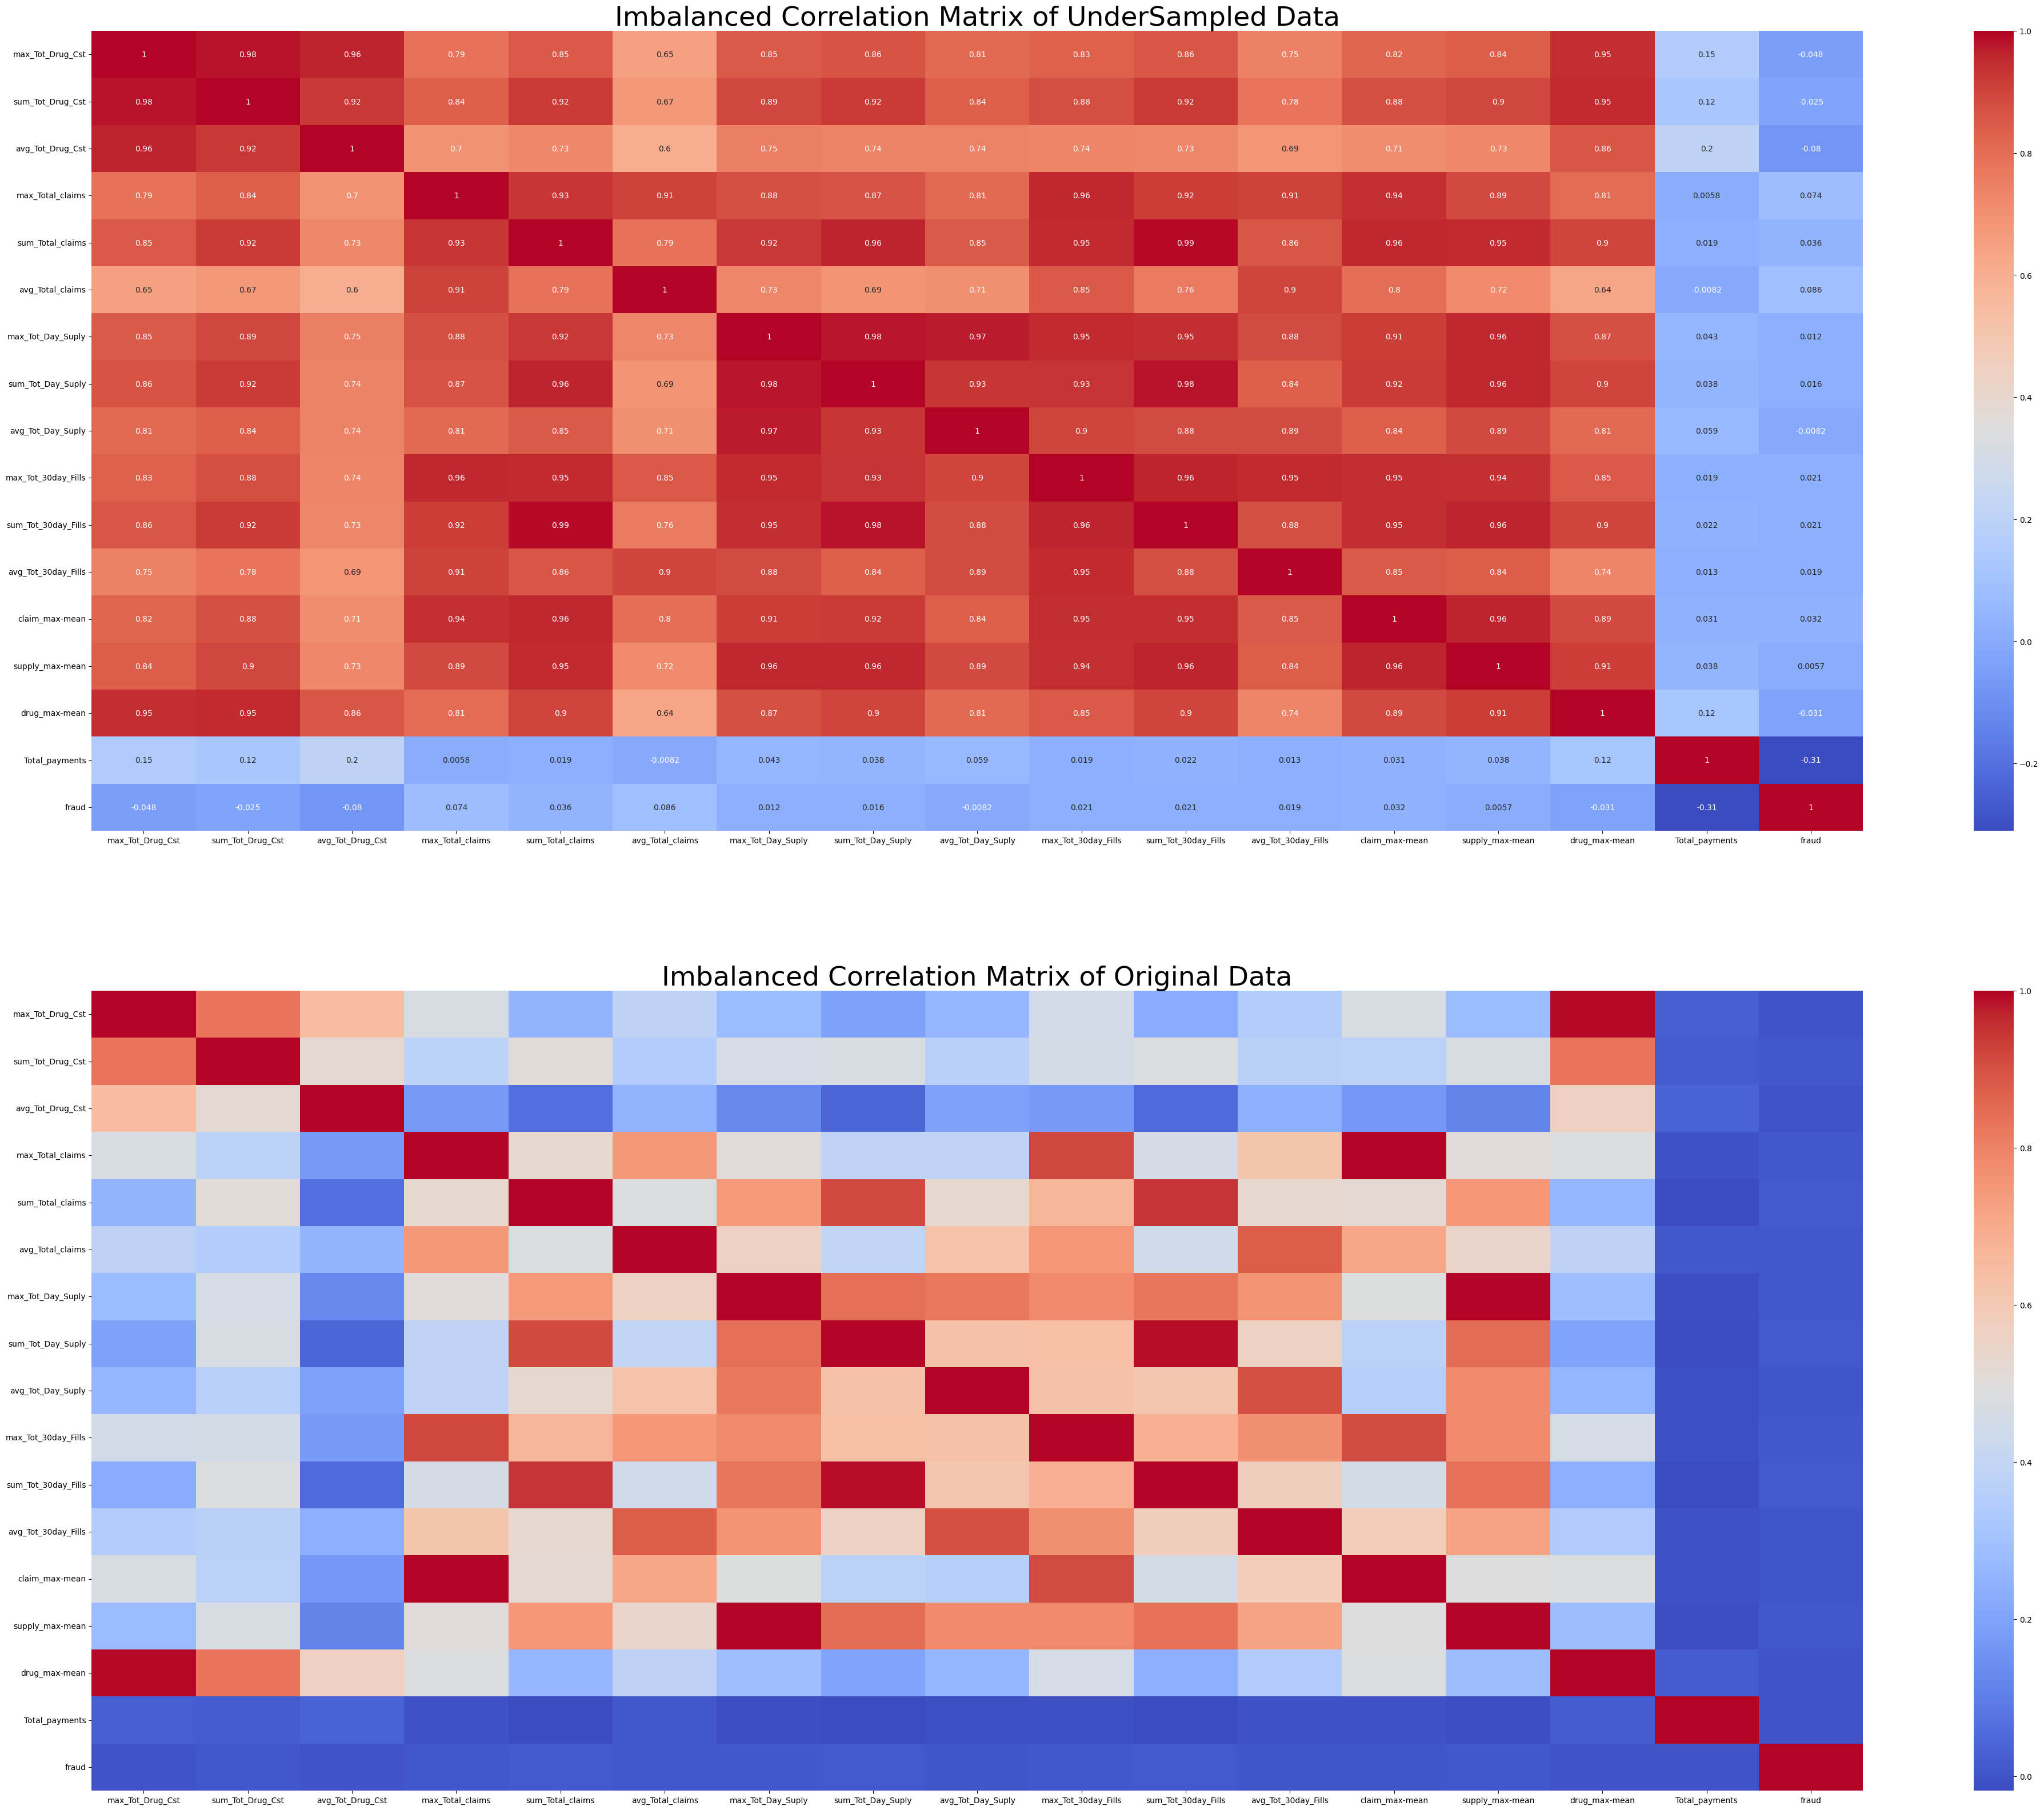

In [61]:
#certainly correlation has increased between attributes and minor increased with target and attributes 

# near miss : Correlation between target and attribute increased with 

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(50,40))      
sns.heatmap(df_under[features].corr(), annot=True, cmap = 'coolwarm', ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix of UnderSampled Data", fontsize=34)

       
sns.heatmap(df_ml[features].corr(), cmap = 'coolwarm', ax=ax2)
ax2.set_title("Imbalanced Correlation Matrix of Original Data", fontsize=34)

#### Box plot

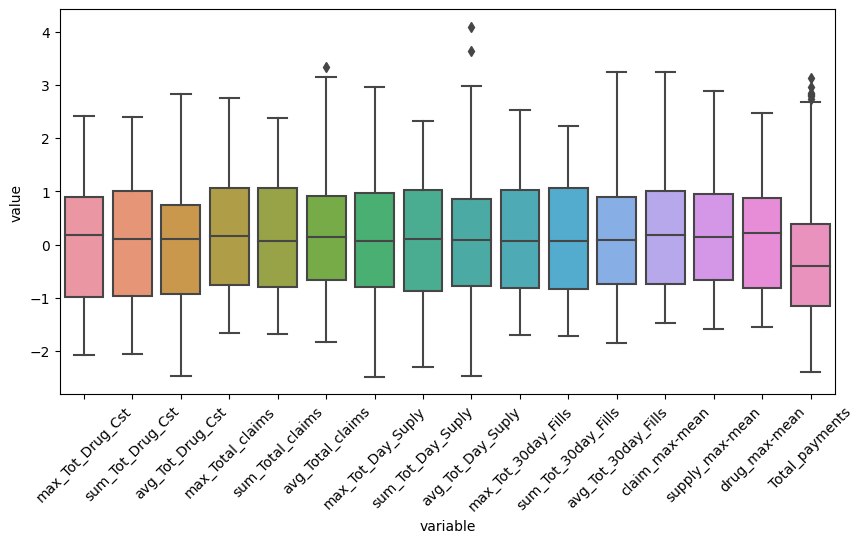

In [64]:
#outliers in avg_total drug cost, avg_total daily supply, claim max mean
plt.figure(figsize=(10,5));
sns.boxplot(x="variable", y="value", data=pd.melt(X_rs[scale_features]));
plt.xticks(rotation = 45);

### Outlier treatment

Before outlier removal (1418, 149)
Remaining after outlier removal (1410, 149)


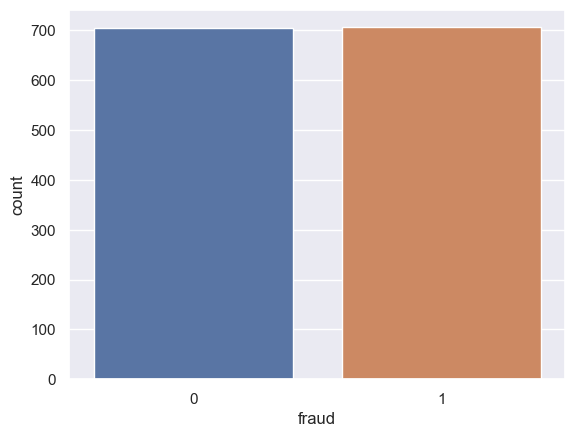

In [65]:
#Now target labels being same, lets see result
#Z-Score method : IQR method tends to remove too many outlier and hence will go with Z-score method.


z = np.abs(stats.zscore(df_under[scale_features]))

df_under_filtered = df_under[(z < 3).all(axis=1)]
print("Before outlier removal",df_under.shape)
print("Remaining after outlier removal",df_under_filtered.shape)
sns.set(style="darkgrid")
ax = sns.countplot(x="fraud", data=df_under_filtered)

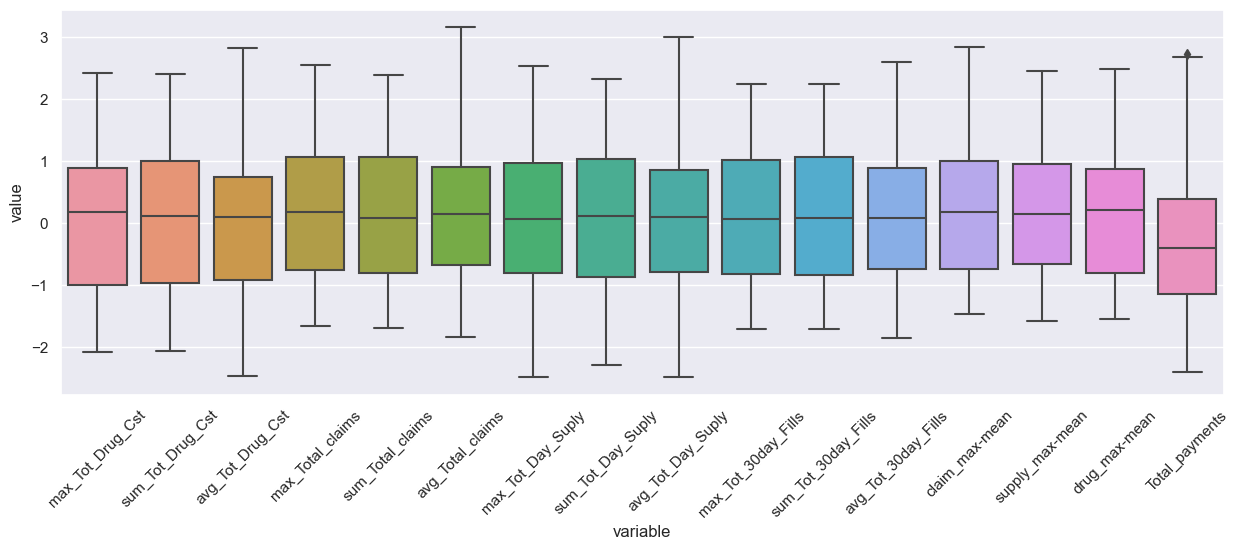

In [66]:
#after outlier treatment

plt.figure(figsize=(15,5));
sns.boxplot(x="variable", y="value", data=pd.melt(df_under_filtered[scale_features]));
plt.xticks(rotation = 45);

### Outlier fixing

In [ ]:
#copying variables to x train and y train

Xx_train = X_rs.copy()
yy_train = y_rs.copy()

In [ ]:
Xx_train.shape

In [ ]:
yy_train.shape

In [ ]:
yy_train.value_counts()

# Model building

## Random forest

In [ ]:

#building a model to get top important features
rf_top = RandomForestClassifier(n_estimators=100, criterion="entropy",random_state=42)
rf_top.fit(Xx_train, yy_train)
#rf_res = predict_and_evaluate(rf_top, X_test, y_test)


feature_importances = pd.Series(rf_top.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
tst = feature_importances.head(30).index.to_list()
tst
#tst has top 30 important features

rf_pre = predict_and_evaluate(rf_top, X_test, y_test)

In [ ]:
print(rf_pre)

In [ ]:
#saving top 40 for future reference

np.savetxt('../top40_without_outlier_treatment.txt', tst, delimiter="\n", fmt="%s")

### Building model with hyper paramter optimization

#####  Full features

In [ ]:
random_grid = {'n_estimators': [200,250,300,350,400,425,450,500,550,600,800],
               'max_features': ['auto','sqrt','log2'],
               'criterion' : ['gini','entropy'],
               'max_depth': [45,50,55,60,70,80,100,120],
               'min_samples_split': [2,3,4,5,6,8,10,12,15],
               'min_samples_leaf': [1,2,3,4,5,6],
               'bootstrap': [True,False] }

In [ ]:
rf_clf = GridSearchCV(RandomForestClassifier(), random_grid,cv = 5,n_jobs=-1)

In [ ]:
# rf_clf = RandomForestClassifier(n_estimators=100, criterion="entropy",random_state=42)

In [ ]:
rf_clf.fit(Xx_train, yy_train)

In [ ]:
#rf_clf.estimators_[0]
print(rf_clf.best_estimator_)
print(rf_clf.best_params_)

In [ ]:
rf_clf

In [ ]:
rf_res = predict_and_evaluate(rf_clf, X_test, y_test)

In [ ]:
joblib.dump(rf_clf,"../models/rf.joblib")

#### On top 30 features

In [ ]:
print("assigning top 40 columns")
top_train = Xx_train[tst]
top_test = X_test[tst]

In [ ]:
rf_top = GridSearchCV(RandomForestClassifier(), random_grid,cv = 5,n_jobs=-1)
rf_top.fit(top_train, yy_train)
rf_pre = predict_and_evaluate(rf_top, top_test, y_test)

In [ ]:
print("RF Top 30 : ")
print(rf_top.best_estimator_)
print(rf_top.best_params_)

In [ ]:
joblib.dump(rf_top,"../models/rf_40.joblib")

# XG Boost

### Full features

In [ ]:
xgb_params = {'n_estimators' : [100,150,200,250,300,350,400,500],
         "learning_rate"    : [0.01,0.02,0.03,0.05,0.10] ,
         "max_depth"        : [ 3,4,5,6,7,8,10,12,13],
         "min_child_weight" : [ 1,2,3,4,5,6,7]}

In [ ]:
xgb_clf = GridSearchCV(XGBClassifier(), xgb_params, n_jobs = -1,cv=5)

In [ ]:
xgb_clf.fit(Xx_train,yy_train)

In [ ]:
xgb_res = predict_and_evaluate(xgb_clf, X_test, y_test)

In [ ]:
print("xgb : ")
print(xgb_clf.best_estimator_)
print(xgb_clf.best_params_)

In [ ]:
joblib.dump(xgb_clf,"../models/xg.joblib")

### Top 30 Features

In [ ]:
xgb_top = GridSearchCV(XGBClassifier(), xgb_params, n_jobs = -1,cv=5)
xgb_top.fit(top_train, yy_train)
xgb_pre = predict_and_evaluate(xgb_top, top_test, y_test)

In [ ]:
print("xgb Top 30 : ")
print(xgb_top.best_estimator_)
print(xgb_top.best_params_)

In [ ]:
joblib.dump(xgb_top,"../models/xg_40.joblib")

# Logistic Regression

### Full features

In [ ]:
log_params = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001,0.002,0.003,0.005, 0.01,0.02,0.04, 0.1, 1, 10, 100]}]



logr = GridSearchCV(linear_model.LogisticRegression(),  
                           param_grid = log_params,
                           cv = 5,
                   )

logr.fit(Xx_train, yy_train)

In [ ]:
logr.fit(Xx_train, yy_train)
print("logR: ")
print(logr.best_estimator_)
print(logr.best_params_)

In [ ]:
val = predict_and_evaluate(logr, X_test, y_test)

In [ ]:
joblib.dump(logr,"../models/log.joblib")

### Top 30 features

In [ ]:
log_top = GridSearchCV(linear_model.LogisticRegression(),  
                           param_grid = log_params,
                           cv = 5,
                   )

log_top.fit(top_train, yy_train)
log_pre = predict_and_evaluate(log_top, top_test, y_test)

In [ ]:
print("logR top 30 : ")
print(log_top.best_estimator_)
print(log_top.best_params_)

In [ ]:
joblib.dump(log_top,"../models/log_40.joblib")

# Cat Boost

### Full features

In [ ]:
cat_parameters = {'depth'         : [4,5,6,7,8,9,10],
                'learning_rate' : [0.01,0.02,0.03,0.04],
                'iterations'    : [40,50,60,70,80,90,100]}
             

In [ ]:
cat_clf = GridSearchCV(CatBoostClassifier(), cat_parameters, n_jobs = -1,cv=5)

In [ ]:
cat_clf.fit(Xx_train,yy_train)

In [ ]:
print(cat_clf)

In [ ]:
print(cat_clf.best_params_)
print(cat_clf.best_estimator_)

In [ ]:
cat_res = predict_and_evaluate(cat_clf, X_test, y_test)

In [ ]:
joblib.dump(cat_clf,"../models/cat.joblib")

### Top 30 features

In [ ]:
cat_top = GridSearchCV(CatBoostClassifier(), cat_parameters, n_jobs = -1,cv=5)
cat_top.fit(top_train, yy_train)
cat_pre = predict_and_evaluate(cat_top, top_test, y_test)

In [ ]:
print(cat_top.best_estimator_)
print(cat_top.best_params_)

In [ ]:
joblib.dump(cat_top,"../models/cat_40.joblib")

# AdaBoost

### Full features

In [ ]:
abc = AdaBoostClassifier(base_estimator=AdaBoostClassifier())

parameters = {'base_estimator':[i for i in range(2,11,2)],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.02,0.03,0.1]}

adaboost = GridSearchCV(abc, parameters,verbose=3,scoring='f1',n_jobs=-1,cv = 5)

In [ ]:
adaboost.fit(Xx_train,yy_train)

In [ ]:
print("adaboost : ")
print(adaboost.best_estimator_)
print(adaboost.best_params_)

In [ ]:
ada_res = predict_and_evaluate(adaboost, X_test, y_test)

In [ ]:
joblib.dump(cat_clf,"../models/ada.joblib")

### Top 30 features

In [ ]:
ada_top = GridSearchCV(abc, parameters,n_jobs=-1,cv = 5)
ada_top.fit(top_train, yy_train)
ada_pre = predict_and_evaluate(ada_top, top_test, y_test)

In [ ]:
print("adaboost top 30 : ")
print(ada_top.best_estimator_)
print(ada_top.best_params_)

In [ ]:
joblib.dump(ada_top,"../models/ada_40.joblib")

## Gradient Boosting

### Full features

In [ ]:
# Parameter matrix for GBM
gbm_params = {  "n_estimators":[100,150,200,250,300,350],
                "learning_rate": [0.01, 0.025,0.03,0.04,0.05],
                "max_depth" : [3,4,5,6],
                "subsample":[ 0.7,0.8, 0.9,1.0,1.1] 
            }

In [ ]:
gbm_clf = GridSearchCV(GradientBoostingClassifier(), gbm_params, n_jobs = -1,
                           cv = 5)

In [ ]:
gbm_clf.fit(Xx_train,yy_train)

In [ ]:
print("gbm_clf :  ")
print(gbm_clf.best_estimator_)
print(gbm_clf.best_params_)

In [ ]:
gbm_res = predict_and_evaluate(gbm_clf, X_test, y_test)

In [ ]:
joblib.dump(gbm_clf,"../models/gbm.joblib")

### Top 30 features

In [ ]:
gbm_top = GridSearchCV(GradientBoostingClassifier(), gbm_params, n_jobs = -1,
                           cv = 5)
gbm_top.fit(top_train, yy_train)
gbm_pre = predict_and_evaluate(gbm_top, top_test, y_test)

In [ ]:
print("gbm top 30  : ")
print(gbm_top.best_estimator_)
print(gbm_top.best_params_)

In [ ]:
joblib.dump(gbm_top,"../models/gbm_40.joblib")

# Multi Layer Perceptron

### Full features

In [ ]:
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 'max_iter': [200],
              'activation': ['tanh', 'relu'],
              'alpha': 10.0 ** -np.arange(1, 10),'learning_rate': ['constant','adaptive'],
              'hidden_layer_sizes':np.arange(5, 15)}
mlp = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1,
                           cv = 5)

In [ ]:
# Fit data onto the model
mlp.fit(Xx_train,yy_train)

In [ ]:
print("mlp : ")
print(mlp.best_estimator_)
print(mlp.best_params_)

In [ ]:
mlp_res = predict_and_evaluate(mlp, X_test, y_test)

In [ ]:
joblib.dump(mlp_res,"../models/mlb.joblib")

### Top 30

In [ ]:
mlp_top = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1,
                           cv = 5)
mlp_top.fit(top_train, yy_train)

In [ ]:
print("mlp  top 30 : ")
print(mlp_top.best_estimator_)
print(mlp_top.best_params_)

In [ ]:
mlp_pre = predict_and_evaluate(mlp_top, top_test, y_test)
joblib.dump(mlp_top,"../models/mlb_40.joblib")

In [ ]:
#FP is it is negative but model predicted positive : precision of model
#FN is it is positive but model predicted negative : recall of model
print("Results with full features")
results = pd.DataFrame(data=[rf_res, xgb_res,cat_res,val,gbm_res,adaboost,mlp_res], 
             columns=('Algorithm','False Positives', 
                      'False Negatives', 'Precision', 
                      'Recall', 'F1 Score',"Accuracy"))


results["Algorithm"] = ["RandomForest","XGBoost","CatBoost","LogisticRegerssion","GBclassifier",
                       "Adaboost","MLP"]

results.to_csv("../results/resuls_full_features.csv")

print(results)

In [ ]:
print("Results with top 40 features")

resultss = pd.DataFrame(data=[rf_pre, xgb_pre,cat_pre,log_pre,gbm_pre,ada_pre,mlp_pre], 
             columns=('Algorithm','False Positives', 
                      'False Negatives', 'Precision', 
                      'Recall', 'F1 Score',"Accuracy"))


results["Algorithm"] = ["RandomForest","XGBoost","CatBoost","LogisticRegerssion","GBclassifier",
                       "Adaboost","MLP"]


resultss.to_csv("../results/resuls_30_features.csv")

print(resultss)